<a href="https://colab.research.google.com/github/aditivin16/AI_Club_RLGames/blob/main/prioritized_replay.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install gym
!pip install matplotlib


In [ ]:
!python script_name.py CartPole-v0 --seeds 10


python3: can't open file '/content/script_name.py': [Errno 2] No such file or directory


In [ ]:
#https://github.com/Howuhh/prioritized_experience_replay/blob/main/README.md

In [ ]:
import gym
import torch
import random
import numpy as np
import torch.nn as nn
import torch.optim as optim


In [ ]:
import os
import torch
import random
import numpy as np


def set_seed(env, seed=0):
    os.environ["PYTHONHASHSEED"] = str(seed)
    env.action_space.seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)


def device(force_cpu=True):
    return "cuda" if torch.cuda.is_available() and not force_cpu else "cpu"

In [ ]:

# The ‘sum-tree’ data structure used here is very similar in spirit to the array representation
# of a binary heap. However, instead of the usual heap property, the value of a parent node is
# the sum of its children. Leaf nodes store the transition priorities and the internal nodes are
# intermediate sums, with the parent node containing the sum over all priorities, p_total. This
# provides a efficient way of calculating the cumulative sum of priorities, allowing O(log N) updates
# and sampling. (Appendix B.2.1, Proportional prioritization)

# Additional useful links
# Good tutorial about SumTree data structure:  https://adventuresinmachinelearning.com/sumtree-introduction-python/
# How to represent full binary tree as array: https://stackoverflow.com/questions/8256222/binary-tree-represented-using-array
class SumTree:
    def __init__(self, size):
        self.nodes = [0] * (2 * size - 1)
        self.data = [None] * size

        self.size = size
        self.count = 0
        self.real_size = 0

    @property
    def total(self):
        return self.nodes[0]

    def update(self, data_idx, value):
        idx = data_idx + self.size - 1  # child index in tree array
        change = value - self.nodes[idx]

        self.nodes[idx] = value

        parent = (idx - 1) // 2
        while parent >= 0:
            self.nodes[parent] += change
            parent = (parent - 1) // 2

    def add(self, value, data):
        self.data[self.count] = data
        self.update(self.count, value)

        self.count = (self.count + 1) % self.size
        self.real_size = min(self.size, self.real_size + 1)

    def get(self, cumsum):
        assert cumsum <= self.total

        idx = 0
        while 2 * idx + 1 < len(self.nodes):
            left, right = 2*idx + 1, 2*idx + 2

            if cumsum <= self.nodes[left]:
                idx = left
            else:
                idx = right
                cumsum = cumsum - self.nodes[left]

        data_idx = idx - self.size + 1

        return data_idx, self.nodes[idx], self.data[data_idx]

    def __repr__(self):
        return f"SumTree(nodes={self.nodes.__repr__()}, data={self.data.__repr__()})"

In [ ]:
import torch
import random
import numpy as np

class PrioritizedReplayBuffer:
    def __init__(self, state_size, action_size, buffer_size, eps=1e-2, alpha=0.1, beta=0.1):
        self.tree = SumTree(size=buffer_size)

        # PER params
        self.eps = eps  # minimal priority, prevents zero probabilities
        self.alpha = alpha  # determines how much prioritization is used, α = 0 corresponding to the uniform case
        self.beta = beta  # determines the amount of importance-sampling correction, b = 1 fully compensate for the non-uniform probabilities
        self.max_priority = eps  # priority for new samples, init as eps

        # transition: state, action, reward, next_state, done
        self.state = torch.empty(buffer_size, state_size, dtype=torch.float)
        self.action = torch.empty(buffer_size, action_size, dtype=torch.float)
        self.reward = torch.empty(buffer_size, dtype=torch.float)
        self.next_state = torch.empty(buffer_size, state_size, dtype=torch.float)
        self.done = torch.empty(buffer_size, dtype=torch.int)

        self.count = 0
        self.real_size = 0
        self.size = buffer_size

    def add(self, transition):
        state, action, reward, next_state, done = transition

        # store transition index with maximum priority in sum tree
        self.tree.add(self.max_priority, self.count)

        # store transition in the buffer
        self.state[self.count] = torch.as_tensor(state)
        self.action[self.count] = torch.as_tensor(action)
        self.reward[self.count] = torch.as_tensor(reward)
        self.next_state[self.count] = torch.as_tensor(next_state)
        self.done[self.count] = torch.as_tensor(done)

        # update counters
        self.count = (self.count + 1) % self.size
        self.real_size = min(self.size, self.real_size + 1)

    def sample(self, batch_size):
        assert self.real_size >= batch_size, "buffer contains less samples than batch size"

        sample_idxs, tree_idxs = [], []
        priorities = torch.empty(batch_size, 1, dtype=torch.float)

        # To sample a minibatch of size k, the range [0, p_total] is divided equally into k ranges.
        # Next, a value is uniformly sampled from each range. Finally the transitions that correspond
        # to each of these sampled values are retrieved from the tree. (Appendix B.2.1, Proportional prioritization)
        segment = self.tree.total / batch_size
        for i in range(batch_size):
            a, b = segment * i, segment * (i + 1)

            cumsum = random.uniform(a, b)
            # sample_idx is a sample index in buffer, needed further to sample actual transitions
            # tree_idx is a index of a sample in the tree, needed further to update priorities
            tree_idx, priority, sample_idx = self.tree.get(cumsum)

            priorities[i] = priority
            tree_idxs.append(tree_idx)
            sample_idxs.append(sample_idx)

        # Concretely, we define the probability of sampling transition i as P(i) = p_i^α / \sum_{k} p_k^α
        # where p_i > 0 is the priority of transition i. (Section 3.3)
        probs = priorities / self.tree.total

        # The estimation of the expected value with stochastic updates relies on those updates corresponding
        # to the same distribution as its expectation. Prioritized replay introduces bias because it changes this
        # distribution in an uncontrolled fashion, and therefore changes the solution that the estimates will
        # converge to (even if the policy and state distribution are fixed). We can correct this bias by using
        # importance-sampling (IS) weights w_i = (1/N * 1/P(i))^β that fully compensates for the non-uniform
        # probabilities P(i) if β = 1. These weights can be folded into the Q-learning update by using w_i * δ_i
        # instead of δ_i (this is thus weighted IS, not ordinary IS, see e.g. Mahmood et al., 2014).
        # For stability reasons, we always normalize weights by 1/maxi wi so that they only scale the
        # update downwards (Section 3.4, first paragraph)
        weights = (self.real_size * probs) ** -self.beta

        # As mentioned in Section 3.4, whenever importance sampling is used, all weights w_i were scaled
        # so that max_i w_i = 1. We found that this worked better in practice as it kept all weights
        # within a reasonable range, avoiding the possibility of extremely large updates. (Appendix B.2.1, Proportional prioritization)
        weights = weights / weights.max()

        batch = (
            self.state[sample_idxs].to(device()),
            self.action[sample_idxs].to(device()),
            self.reward[sample_idxs].to(device()),
            self.next_state[sample_idxs].to(device()),
            self.done[sample_idxs].to(device())
        )
        return batch, weights, tree_idxs

    def update_priorities(self, data_idxs, priorities):
        if isinstance(priorities, torch.Tensor):
            priorities = priorities.detach().cpu().numpy()

        for data_idx, priority in zip(data_idxs, priorities):
            # The first variant we consider is the direct, proportional prioritization where p_i = |δ_i| + eps,
            # where eps is a small positive constant that prevents the edge-case of transitions not being
            # revisited once their error is zero. (Section 3.3)
            priority = (priority + self.eps) ** self.alpha

            self.tree.update(data_idx, priority)
            self.max_priority = max(self.max_priority, priority)


class ReplayBuffer:
    def __init__(self, state_size, action_size, buffer_size):
        # state, action, reward, next_state, done
        self.state = torch.empty(buffer_size, state_size, dtype=torch.float)
        self.action = torch.empty(buffer_size, action_size, dtype=torch.float)
        self.reward = torch.empty(buffer_size, dtype=torch.float)
        self.next_state = torch.empty(buffer_size, state_size, dtype=torch.float)
        self.done = torch.empty(buffer_size, dtype=torch.int)

        self.count = 0
        self.real_size = 0
        self.size = buffer_size

    def add(self, transition):
        state, action, reward, next_state, done = transition

        # store transition in the buffer
        self.state[self.count] = torch.as_tensor(state)
        self.action[self.count] = torch.as_tensor(action)
        self.reward[self.count] = torch.as_tensor(reward)
        self.next_state[self.count] = torch.as_tensor(next_state)
        self.done[self.count] = torch.as_tensor(done)

        # update counters
        self.count = (self.count + 1) % self.size
        self.real_size = min(self.size, self.real_size + 1)

    def sample(self, batch_size):
        assert self.real_size >= batch_size

        sample_idxs = np.random.choice(self.real_size, batch_size, replace=False)

        batch = (
            self.state[sample_idxs].to(device()),
            self.action[sample_idxs].to(device()),
            self.reward[sample_idxs].to(device()),
            self.next_state[sample_idxs].to(device()),
            self.done[sample_idxs].to(device())
        )
        return batch

In [ ]:
from copy import deepcopy

In [ ]:
! --seeds 10 CartPole-v0

/bin/bash: line 1: --seeds: command not found


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns 

Training on: CartPole-v0, Device: cpu, Seed: 0
Episode: 313, Step: 5000, Reward mean: 38.70, Reward std: 8.06, Loss: 4.5669, Eps: 0.44375
Episode: 438, Step: 10000, Reward mean: 69.90, Reward std: 44.41, Loss: 6.5779, Eps: 0.3875
Episode: 498, Step: 15000, Reward mean: 123.90, Reward std: 33.74, Loss: 8.4101, Eps: 0.33125
Episode: 545, Step: 20000, Reward mean: 148.60, Reward std: 32.40, Loss: 10.3657, Eps: 0.275
Episode: 581, Step: 25000, Reward mean: 164.80, Reward std: 28.84, Loss: 11.9117, Eps: 0.21875
Episode: 610, Step: 30000, Reward mean: 193.00, Reward std: 14.99, Loss: 12.9982, Eps: 0.16249999999999998
Episode: 637, Step: 35000, Reward mean: 193.90, Reward std: 18.30, Loss: 13.7581, Eps: 0.10625000000000001
Episode: 664, Step: 40000, Reward mean: 193.60, Reward std: 19.20, Loss: 14.3482, Eps: 0.04999999999999999
Training on: CartPole-v0, Device: cpu, Seed: 0
Episode: 261, Step: 5000, Reward mean: 38.20, Reward std: 3.71, Loss: 2.3073, Eps: 0.44375
Episode: 323, Step: 10000, Re

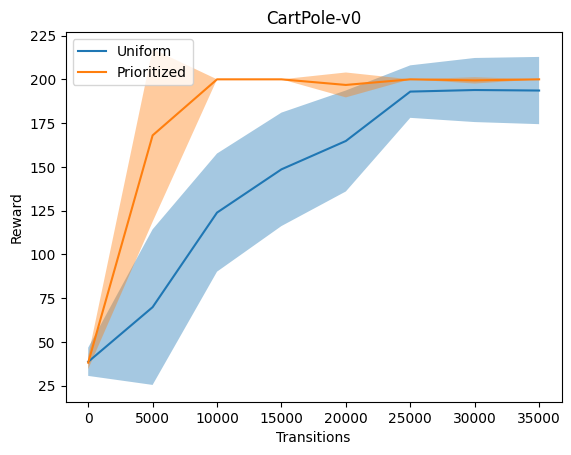

In [ ]:

class DQN:
    def __init__(self, state_size, action_size, gamma, tau, lr):
        self.model = nn.Sequential(
            nn.Linear(state_size, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, action_size)
        ).to(device())
        self.target_model = deepcopy(self.model).to(device())
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)

        self.gamma = gamma
        self.tau = tau

    def soft_update(self, target, source):
        for tp, sp in zip(target.parameters(), source.parameters()):
            tp.data.copy_((1 - self.tau) * tp.data + self.tau * sp.data)

    def act(self, state):
        with torch.no_grad():
            state = torch.as_tensor(state, dtype=torch.float).to(device())
            action = torch.argmax(self.model(state)).cpu().numpy().item()
        return action

    def update(self, batch, weights=None):
        state, action, reward, next_state, done = batch

        Q_next = self.target_model(next_state).max(dim=1).values
        Q_target = reward + self.gamma * (1 - done) * Q_next
        Q = self.model(state)[torch.arange(len(action)), action.to(torch.long).flatten()]

        assert Q.shape == Q_target.shape, f"{Q.shape}, {Q_target.shape}"

        if weights is None:
            weights = torch.ones_like(Q)

        td_error = torch.abs(Q - Q_target).detach()
        loss = torch.mean((Q - Q_target)**2 * weights)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        with torch.no_grad():
            self.soft_update(self.target_model, self.model)

        return loss.item(), td_error

    def save(self):
        torch.save(self.model, "agent.pkl")


def evaluate_policy(env_name, agent, episodes=5, seed=0):
    env = gym.make(env_name)
    set_seed(env, seed=seed)

    returns = []
    for ep in range(episodes):
        done, total_reward = False, 0
        state = env.reset(seed=seed + ep)

        while not done:
            action = agent.act(state)
            state, reward, done, _, = env.step(action)
            total_reward += reward

        returns.append(total_reward)

    return np.mean(returns), np.std(returns)


def train(env_name, model, buffer, timesteps=200_000, batch_size=128,
          eps_max=0.1, eps_min=0.0, test_every=5000, seed=0):
    print(f"Training on: {env_name}, Device: {device()}, Seed: {seed}")

    env = gym.make(env_name)

    rewards_total, stds_total = [], []
    loss_count, total_loss = 0, 0

    episodes = 0
    best_reward = -np.inf

    done = False
    state = env.reset()

    for step in range(1, timesteps + 1):
        if done:
            done = False
            state = env.reset()
            episodes += 1

        eps = eps_max - (eps_max - eps_min) * step / timesteps

        if random.random() < eps:
            action = env.action_space.sample()
        else:
            action = model.act(state)

        next_state, reward, done, _ = env.step(action)
        buffer.add((state, action, reward, next_state, int(done)))

        state = next_state

        if step > batch_size:
            if isinstance(buffer, ReplayBuffer):
                batch = buffer.sample(batch_size)
                loss, td_error = model.update(batch)
            elif isinstance(buffer, PrioritizedReplayBuffer):
                batch, weights, tree_idxs = buffer.sample(batch_size)
                loss, td_error = model.update(batch, weights=weights)

                buffer.update_priorities(tree_idxs, td_error.numpy())
            else:
                raise RuntimeError("Unknown buffer")

            total_loss += loss
            loss_count += 1

            if step % test_every == 0:
                mean, std = evaluate_policy(env_name, model, episodes=10, seed=seed)

                print(f"Episode: {episodes}, Step: {step}, Reward mean: {mean:.2f}, Reward std: {std:.2f}, Loss: {total_loss / loss_count:.4f}, Eps: {eps}")

                if mean > best_reward:
                    best_reward = mean
                    model.save()

                rewards_total.append(mean)
                stds_total.append(std)

    return np.array(rewards_total), np.array(stds_total)


def run_experiment(config, use_priority=False, n_seeds=10):
    torch.manual_seed(0)
    mean_rewards = []

    for seed in range(n_seeds):
        if use_priority:
            buffer = PrioritizedReplayBuffer(**config["buffer"])
        else:
            buffer = ReplayBuffer(**config["buffer"])
        model = DQN(**config["model"])

        seed_reward, seed_std = train(seed=seed, model=model, buffer=buffer, **config["train"])
        mean_rewards.append(seed_reward)

    mean_rewards = np.array(mean_rewards)

    return mean_rewards.mean(axis=0), mean_rewards.std(axis=0)


if __name__ == "__main__":
    import argparse
    import matplotlib.pyplot as plt

    env_name = "CartPole-v0"  # Set the environment name

    config = {
        "buffer": {
            "state_size": 4,  # Change state_size to 4 for CartPole-v0
            "action_size": 1,  # action is discrete
            "buffer_size": 50_000
        },
        "model": {
            "state_size": 4,
            "action_size": 2,
            "gamma": 0.99,
            "lr": 1e-4,
            "tau": 0.01
        },
        "train": {
            "timesteps": 40_000,
            "batch_size": 64,
            "test_every": 5000,
            "eps_max": 0.5,
            "eps_min": 0.05
        }
    }

    priority_config = deepcopy(config)
    priority_config["buffer"].update({"alpha": 0.7, "beta": 0.4})

    mean_reward, std_reward = train(env_name, DQN(**config["model"]), ReplayBuffer(**config["buffer"]), **config["train"])
    mean_priority_reward, std_priority_reward = train(env_name, DQN(**config["model"]), PrioritizedReplayBuffer(**priority_config["buffer"]), **priority_config["train"])

    steps = np.arange(mean_reward.shape[0]) * config["train"]["test_every"]

    plt.plot(steps, mean_reward, label="Uniform")
    plt.fill_between(steps, mean_reward - std_reward, mean_reward + std_reward, alpha=0.4)
    plt.plot(steps, mean_priority_reward, label="Prioritized")
    plt.fill_between(steps, mean_priority_reward - std_priority_reward, mean_priority_reward + std_priority_reward, alpha=0.4)

    plt.legend()
    plt.title(env_name)
    plt.xlabel("Transitions")
    plt.ylabel("Reward")
